### TODO
- add "mal functionning meter (value=0 for a ~large period)" detection

In [1]:
import os
import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
data_folder = os.path.join("data", "work")
os.listdir(data_folder)[:5]

['idb475-met0.csv',
 'idb534-met0.csv',
 'idb948-met1.csv',
 'idb35-met0.csv',
 'idb1164-met0.csv']

In [3]:
file = os.listdir(data_folder)[1]
filepath = os.path.join(data_folder, file)
df = pd.read_csv(filepath, parse_dates=True)
df["meter_reading"] = df["meter_reading"].clip(upper = df["meter_reading"].quantile(.999))
site_id = df.iloc[0]["site_id"]

In [4]:
meters = {0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}
meter = meters[int(file.split("met")[1].split(".")[0])]
meter

'electricity'

In [5]:
def set_proper_datetime(dataframe):
    dataframe["timestamp"] = pd.to_datetime(dataframe["timestamp"])
    dataframe["hod"] = dataframe["timestamp"].dt.hour
    # dataframe["doy"] = dataframe["timestamp"].dt.day
    dataframe["dow"] = dataframe["timestamp"].dt.weekday
    # dataframe["month"] = dataframe["timestamp"].dt.month
    dataframe.set_index("timestamp", drop=True, inplace=True)

In [6]:
set_proper_datetime(df)
df = df.iloc[:, 1:]
df.head()

building_id  meter  meter_reading  site_id  \
timestamp                                                         
2016-01-01 00:00:00          534      0           1.36        3   
2016-01-01 01:00:00          534      0           1.36        3   
2016-01-01 02:00:00          534      0           1.36        3   
2016-01-01 03:00:00          534      0           1.36        3   
2016-01-01 04:00:00          534      0           1.36        3   

                                       primary_use  square_feet  year_built  \
timestamp                                                                     
2016-01-01 00:00:00  Entertainment/public assembly          898         NaN   
2016-01-01 01:00:00  Entertainment/public assembly          898         NaN   
2016-01-01 02:00:00  Entertainment/public assembly          898         NaN   
2016-01-01 03:00:00  Entertainment/public assembly          898         NaN   
2016-01-01 04:00:00  Entertainment/public assembly          898         NaN   

                     floor_count  air_temperature  cloud_coverage  \
timestamp                                                           
2016-01-01 00:00:00          NaN             10.0             8.0   
2016-01-01 01:00:00          NaN              9.4             NaN   
2016-01-01 02:00:00          NaN              8.9             NaN   
2016-01-01 03:00:00          NaN              7.8             8.0   
2016-01-01 04:00:00          NaN              7.8             NaN   

                     dew_temperature  precip_depth_1_hr  sea_level_pressure  \
timestamp                                                                     
2016-01-01 00:00:00              2.2                NaN              1021.1   
2016-01-01 01:00:00              2.8                0.0              1021.5   
2016-01-01 02:00:00              2.2                0.0              1021.7   
2016-01-01 03:00:00              1.1                0.0              1021.7   
2016-01-01 04:00:00              0.6                0.0              1021.8   

                     wind_direction  wind_speed  GB_holidays  US_holidays  \
timestamp                                                                   
2016-01-01 00:00:00           350.0         4.1          1.0          1.0   
2016-01-01 01:00:00           350.0         6.2          1.0          1.0   
2016-01-01 02:00:00            10.0         4.6          1.0          1.0   
2016-01-01 03:00:00           350.0         7.7          1.0          1.0   
2016-01-01 04:00:00           340.0         4.1          1.0          1.0   

                     hod  dow  
timestamp                      
2016-01-01 00:00:00    0    4  
2016-01-01 01:00:00    1    4  
2016-01-01 02:00:00    2    4  
2016-01-01 03:00:00    3    4  
2016-01-01 04:00:00    4    4

In [7]:
df.iloc[:, 8:].columns

Index(['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'GB_holidays', 'US_holidays', 'hod', 'dow'],
      dtype='object')

In [8]:
X = df.iloc[:, 8:].values
y = df.meter_reading.values

idx = list(range(len(df)))
np.random.shuffle(idx)
n = int(len(idx)*0.1)

X_valid, X_train = X[idx[:n]], X[idx[n:]]
y_valid, y_train = y[idx[:n]], y[idx[n:]]

In [9]:
my_model = XGBRegressor(n_estimators=250, learning_rate=0.25, n_jobs=8)
my_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=5, verbose=False);

[18:03:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
predictions = np.clip(my_model.predict(X_valid), a_min=0, a_max=None)
print("Mean Squ. Error: {:.2}".format(mean_squared_error(predictions, y_valid)))
print("Mean Abs. Error: {:.2}".format(mean_absolute_error(predictions, y_valid)))

Mean Squ. Error: 0.74
Mean Abs. Error: 0.6


In [11]:
filepath = os.path.join("data", "ashrae-energy-prediction", 'weather_train_holidays.csv')
weather_train = pd.read_csv(filepath, parse_dates=True, index_col=0)
weather_train = weather_train.loc[weather_train.site_id == site_id]
set_proper_datetime(weather_train)
weather_train.drop("site_id", inplace=True, axis=1)
weather_train.head(2)

air_temperature  cloud_coverage  dew_temperature  \
timestamp                                                               
2016-01-01 00:00:00             10.0             8.0              2.2   
2016-01-01 01:00:00              9.4             NaN              2.8   

                     precip_depth_1_hr  sea_level_pressure  wind_direction  \
timestamp                                                                    
2016-01-01 00:00:00                NaN              1021.1           350.0   
2016-01-01 01:00:00                0.0              1021.5           350.0   

                     wind_speed  GB_holidays  US_holidays  hod  dow  
timestamp                                                            
2016-01-01 00:00:00         4.1            1            1    0    4  
2016-01-01 01:00:00         6.2            1            1    1    4

In [12]:
filepath = os.path.join("data", "ashrae-energy-prediction", 'weather_test_holidays.csv')
weather_test = pd.read_csv(filepath, parse_dates=True, index_col=0)
weather_test = weather_test.loc[weather_test.site_id == site_id]
set_proper_datetime(weather_test)
weather_test.drop("site_id", inplace=True, axis=1)
weather_test.head(2)

air_temperature  cloud_coverage  dew_temperature  \
timestamp                                                               
2017-01-01 00:00:00              8.9             8.0             -5.6   
2017-01-01 01:00:00              8.3             NaN             -4.4   

                     precip_depth_1_hr  sea_level_pressure  wind_direction  \
timestamp                                                                    
2017-01-01 00:00:00                NaN              1015.3           190.0   
2017-01-01 01:00:00               -1.0              1014.9           210.0   

                     wind_speed  GB_holidays  US_holidays  hod  dow  
timestamp                                                            
2017-01-01 00:00:00         8.2            1            1    0    6  
2017-01-01 01:00:00         8.8            1            1    1    6

In [13]:
df["preds"] = np.clip(my_model.predict(X), a_min=0, a_max=None)
weather_train["preds_full"] = np.clip(my_model.predict(weather_train.values), a_min=0, a_max=None)

<IPython.core.display.Javascript object>


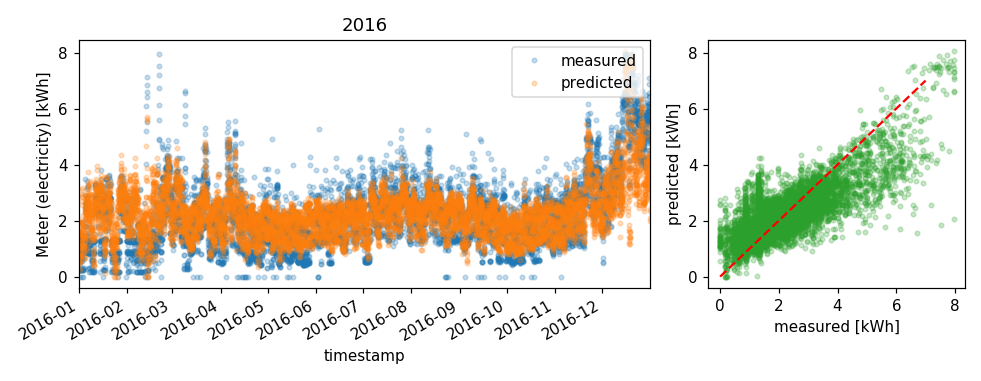

In [14]:
fig = plt.figure(figsize=(9, 3.5))
grid = plt.GridSpec(1, 3)
ax = [plt.subplot(grid[0, :-1]), plt.subplot(grid[0,-1:])]

df.meter_reading.plot(ax=ax[0], marker=".", linestyle="", alpha=0.25, color="C0", label="measured")
weather_train.preds_full.plot(ax=ax[0], marker=".", linestyle="", alpha=0.25, color="C1", label="predicted")
ax[0].legend(loc=1)
ax[0].set_ylabel("Meter ({}) [kWh]".format(meter))
ax[0].set_title("2016")

ax[1].plot(df.meter_reading, df.preds, ".", alpha=0.25, color="C2")
z = int(max(df.meter_reading.max(), df.preds.max()))
ax[1].plot(range(z), range(z), "--", color="r")
ax[1].set_xlabel("measured [kWh]")
ax[1].set_ylabel("predicted [kWh]")

fig.tight_layout()

In [15]:
models_folder = os.path.join("data", "models")

model_path = os.path.join(models_folder, file.split(".")[0]+'.model')
my_model.save_model(model_path)

In [16]:
model = XGBRegressor(n_estimators=250, learning_rate=0.25, n_jobs=8)
model.load_model(model_path)
weather_test["preds_full"]= np.clip(model.predict(weather_test.values), a_min=0, a_max=None)

[18:03:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<IPython.core.display.Javascript object>


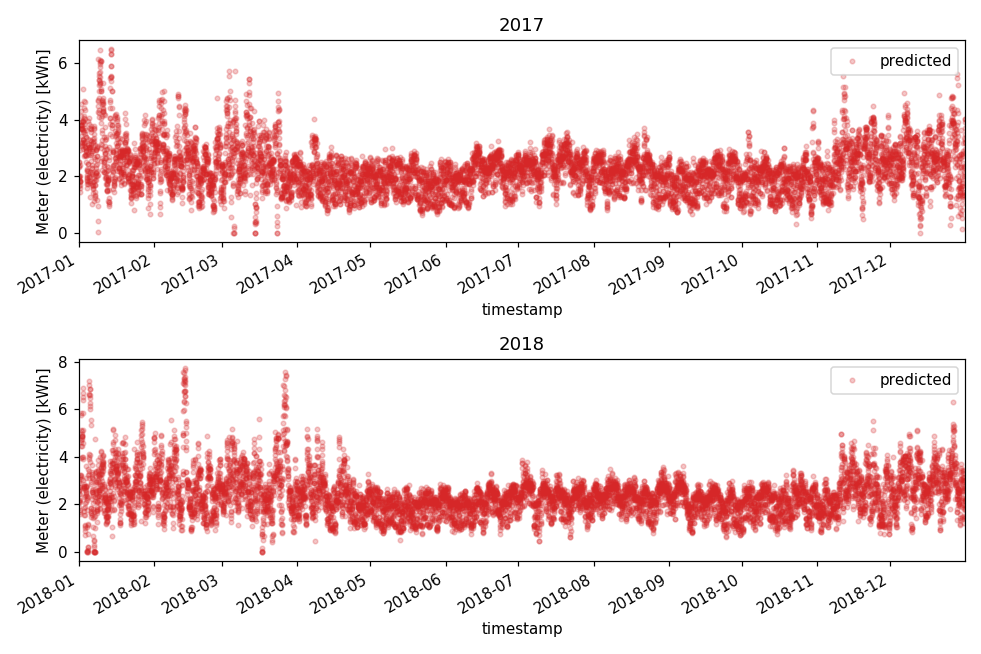

In [17]:
fig, ax = plt.subplots(2, figsize=(9, 6))
for i, year in enumerate([2017, 2018]):
    weather_test.loc[str(year)].preds_full.plot(ax=ax[i], marker=".", linestyle="", alpha=0.25, color="C3", label="predicted")
    ax[i].legend(loc=1)
    ax[i].set_ylabel("Meter ({}) [kWh]".format(meter))
    ax[i].set_title(year)
fig.tight_layout()